In [4]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
from copy import deepcopy
import math

CODE FOR SIMULATING THE NETWORK AND CALCULATING THE MAXIMUM LYAPUNOV COEFFICIENT OF THE MSF

In [5]:
alpha = 2
beta = 2
gamma = 1
epsilon = 0.1
I = -1.3

STEADY_STATE = np.array([0.4586,0.9173]) #np.array([1.099, 2.198])
H = np.array([[1,0], [0, 0]]) #coupling matrix
sigma = 1
delay = 0
PERTURBATION = 1e-4 #was 1e-2 before

#Neuron coupling matrix for a ring with number of neurons = dim
def Diffusive_ring_matrix(dim):
    assert dim > 2, "dimension must be > 2"
    temp = np.zeros((dim, dim))
    col = 0
    for row in range(1, dim-1):
        col += 1
        temp[row, col-1] = 1
        temp[row, col] = -2
        temp[row, col+1] = 1
    temp[0][0] = -2
    temp[0][1] = 1
    temp[0][-1] = 1
    temp[-1][0] = 1
    temp[-1][-1] = -2
    temp[-1][-2] = 1
    return temp

#coupling matrix for a ring of neurons with only one direction of propagation
def One_way_ring_matrix(dim):
    temp = np.zeros((dim, dim))
    for i in range(dim-1):
        temp[i][i+1] = 1
    temp[dim-1][0] = 1
    return temp

#coupling matrix for a ring of neurons with only one direction of propagation and diffusion between neurons
def One_way_diffusive_ring_matrix(dim, x, y):
    temp = np.zeros((dim, dim))
    for i in range(dim-1):
        temp[i][i] = -x
        temp[i][i+1] = y
    temp[dim-1][0] = y
    temp[dim-1][dim-1] = -x
    return temp


#Jacobian evaluated at x = [v, w]
def DF(x):
    return np.array([[-3*x[0]**2+2*x[0]*(alpha+1)-alpha, -1], [epsilon*beta, -epsilon*gamma]])

#Master stability function for FHN system
def MSF(v, x, x_delayed):
    return (DF(STEADY_STATE) - sigma*H).dot(x)+(sigma*v*H).dot(x_delayed)

#Lyapunov coefficient calc, OLD version
def Lyapunov_calc(v, IC, steps_threshold, steps_total, time_step, maximum):
    IC = np.array(IC, dtype = np.longdouble)
    delay_list_length = int(delay/time_step + 1)
    Xs = [IC for i in range(delay_list_length)]
    X = deepcopy(IC)
    out = [X[0]]
    Y = deepcopy(IC)
    Y += np.array([PERTURBATION/math.sqrt(IC.size) for i in range(IC.size)], dtype = np.longdouble)
    print(X, Y)
    
    total = 0
    skipped = 0
    for step in range(steps_total):
        X = X + time_step * MSF(v, X, Xs[0])
        
        if complex_2_norm(X) > maximum:
            if total > 0:
                return total / (steps_total - skipped - steps_threshold)
            else:
                return 100
            
        Y = Y + time_step * MSF(v, Y, Xs[0])
        Xs.append(X)
        out.append(X[0])
        Xs = Xs[1:len(Xs)]
        delta = X - Y
        dist = np.linalg.norm(delta)
        #dist = complex_2_norm(delta)
        if dist == 0:
            print(f'{step = }, {X = }, {Y = }, {(X==Y).all()}')
        if step > steps_threshold:
            if dist > 0:
                total += math.log(dist/(PERTURBATION))
            else:
                skipped += 1
        if (X == Y).all():
            Y += np.array([PERTURBATION/math.sqrt(IC.size) for i in range(IC.size)], dtype = np.longdouble)
        else:
            Y = X + (PERTURBATION/dist) * delta
    total /= (steps_total - skipped - steps_threshold)
    print(steps_total - skipped - steps_threshold)
    
    plt.plot(out)
    
    return total / time_step
    
#Lyapunov coefficient calc, NEW version    
def Lyapunov_calc_2(v, centre, radius, point_num, steps_threshold, steps_total, time_step, maximum):
    
    centre = np.array(centre)
    ICs = [centre + np.array([np.cos(2*n*math.pi/point_num), np.sin(2*n*math.pi/point_num)]) for n in range(point_num)]
    big_total = 0
    for IC in ICs:
    
        IC = np.array(IC, dtype = np.longdouble)
        delay_list_length = int(delay/time_step + 1)
        Xs = [IC for i in range(delay_list_length)]
        Ys = [IC for i in range(delay_list_length)]
        X = deepcopy(IC)
        Y = deepcopy(IC)
        Y += np.array([PERTURBATION/math.sqrt(IC.size) for i in range(IC.size)], dtype = np.longdouble)

        dist_current = PERTURBATION
        total = 0
        skipped = 0
        for step in range(steps_total):
            X = X + time_step * MSF(v, X, Xs[0])

            if complex_2_norm(X) > maximum:
                if total > 0:
                    return total / (step - skipped - steps_threshold)
                else:
                    return 100

            Y = Y + time_step * MSF(v, Y, Ys[0])
            Xs.append(X)
            Xs = Xs[1:len(Xs)]
            Ys.append(Y)
            Ys = Ys[1:len(Ys)]

            delta = X - Y
            #dist = np.linalg.norm(delta)
            dist = complex_2_norm(delta)

            if step > steps_threshold:
                if dist > 0:
                    total += math.log(dist/dist_current)
                else:
                    skipped += 1

            dist_current = deepcopy(dist)

            if (X == Y).all():
                Y += np.array([PERTURBATION/math.sqrt(IC.size) for i in range(IC.size)], dtype = np.longdouble)
                dist_current = PERTURBATION

        total /= (steps_total - skipped - steps_threshold) * time_step
        big_total += total
    
    return big_total / point_num  
    
#kronecker product    
def Kronecker(m1, m2):
    m1 = np.array(m1)
    m2 = np.array(m2)
    (m,n) = m1.shape
    (j,k) = m2.shape
    assert len(m1.shape) == 2, "Must be a matrix"
    assert len(m2.shape) == 2, "Must be a matrix"
    out = np.zeros((m*j, n*k))
    for r in range(m*j):
        for c in range(n*k):
            out[r][c] = m1[math.floor(r/j)][math.floor(c/k)] * m2[r % j][c % k]
    return out

#FitzHugh-Nagumo system
def fhn(activations, alpha, beta, gamma, epsilon, I):
    v, w = activations[0], activations[1]
    dv = v*(v-alpha)*(1-v)-w-I
    dw = epsilon*(beta*v-gamma*w)
    return [dv, dw]

#FitzHugh-Nagumo for a graph
def graph_fhn(activations, alpha, beta, gamma, epsilon, I):
    variables = [[activations[i], activations[i+1]] for i in range(0, len(activations), 2)]
    temp = []
    for var in variables:
        temp.append(fhn(var, alpha, beta, gamma, epsilon, I))
    out = [0 for i in range(2*len(temp))]
    for i in range(len(temp)):
        out[2*i] = temp[i][0]
        out[2*i+1] = temp[i][1]
    return out

#Complex 2-norm of a vector
def complex_2_norm(arr):
    total = 0
    for x in arr:
        if type(x) == Complex:
            x = math.sqrt(x.re**2 + x.im**2)
        total += x**2
    return math.sqrt(total)

#complex number class
class Complex():
    def __init__(self, a, b):
        self.re = a
        self.im = b
        
    def __add__(self, other):
        if type(other) in {int, float, np.int32, np.float32, np.longdouble}:
            other = Complex(other, 0)
        return Complex(self.re + other.re, self.im + other.im)
    
    def __radd__(self, other):
        return self + other
    
    def __sub__(self, other):
        return self + ((-1) * other)
    
    def __rsub__(self, other):
        return self - other
    
    def __mul__(self, other):
        if type(other) in {float, int, np.float32, np.int32, np.longdouble}:
            other = Complex(other, 0)
        if type(other) == np.ndarray:
            (R, C) = other.shape
            out = [[0 for c in range(C)] for r in range(R)]
            for r in range(R):
                for c in range(C):
                    out[r][c] = self * other[r,c]
            return np.array(out)
        return Complex((self.re*other.re)-(self.im*other.im), (self.re*other.im)+(self.im*other.re))
    
    def __rmul__(self, other):
        return self * other
    
    def __repr__(self):
        return f'({self.re})+i({self.im})'

#function for simulationg the graph with FHN, returns a list with all the activations of all the vertices
def simulate_graph(function_system, activations, coupling_factor, coupling_matrix, diffusion_matrix, delay, time_step, total_time,
                   alpha, beta, gamma, epsilon, I, g_hat): #activations = time vector of activation vectors
    
    assert coupling_matrix.shape[0] == coupling_matrix.shape[1], "Coupling matrix must be square"
    assert diffusion_matrix.shape[0] == diffusion_matrix.shape[1], "Coupling matrix must be square"
    assert activations.size == coupling_matrix.shape[0] * diffusion_matrix.shape[0], "Dim(a) must be equal to Dim(H)*Dim(G)"
    
    time_len = int(delay / time_step) + 1
    activations_delay = [activations for i in range(time_len)]
    total_steps = int(total_time/time_step)
    
    for step in range(total_steps):
        dadt = function_system(activations_delay[-1], alpha, beta, gamma, epsilon, I) - g_hat * coupling_factor * Kronecker(np.identity(coupling_matrix.shape[0]), diffusion_matrix).dot(activations_delay[-1]) + \
               coupling_factor * Kronecker(coupling_matrix, diffusion_matrix).dot(activations_delay[step])
        activations = activations + time_step * dadt
        activations_delay.append(activations)
        
    return activations_delay

In [6]:
#random matrix with 0s on diagonal, scaled so that row sum is 1 
def random_scaled(dim):
    temp = np.random.randint(-10, 10, size = (dim, dim))
    temp = np.array(temp, dtype = 'float32')
    for i in range(dim):
        temp[i][i]=0
        total = np.sum(temp[i])
        if total == 0:
            temp[i][0] += 1
            total = np.sum(temp[i])
        for j in range(dim):
            temp[i][j] /= total
    return temp

In [7]:
def augmented_one_way_matrix(x, dim):
    assert dim >= 4, "dim must be >= 4"
    temp = np.zeros((dim, dim))
    for i in range(dim-1):
        temp[i][i+1] = 1
        temp[dim-1][0]=1
    temp[0][2], temp[0][3] = x, -x
    return temp

In [8]:
#4x4 matrix with 2 of eigenvalues x, -x, row sum of 1
def used_mat(x):
    temp = np.zeros((4,4))
    temp[0][3] = 1
    temp[3][0] = 1
    temp[1][2] = x
    temp[1][3] = -(x-1)
    temp[2][0] = -(x-1)
    temp[2][1] = x
    return temp

Simulating the network

In [529]:
a = np.zeros(8) #initial conditions
a.fill(0)
for i in range(int(a.size/2)):
    break
    a[2*i+1] = 2.198

a[0] += 0.1
a[2] -= 0.03
a[4] += 0.05
a[6] -= 0.1

cf = 1 #coupling factor, sigma

#cm = 1 * One_way_diffusive_ring_matrix(2, 0, 1)
#cm = 0.1 * np.identity(8)
cm = used_mat(10)  #coupling matrix
#cm = np.array([[0,3,-1,-1],[2,0,0,-1],[1,4,0,-4],[-2,2,1,0]])

dm = np.array([[1,0],[0,0]]) #diffusion matrix
tau = 5 #time delay
time_step = 1e-3
total_time = 800
graph = np.array(simulate_graph(graph_fhn, a, cf, cm, dm, tau, time_step, total_time, 2, 2, 1, 0.01, -2.1, 1))

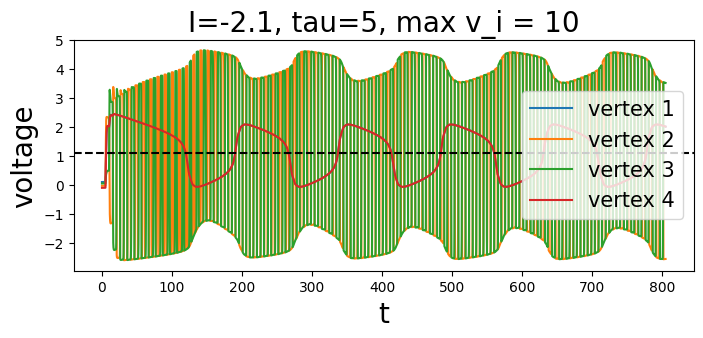

In [531]:
fig = plt.figure(figsize=(8,3))
ax = fig.add_subplot(111)
ax.plot([i*1e-3 for i in range(int(total_time/time_step + tau/time_step + 1))], graph[:,0], label = "vertex 1")
ax.plot([i*1e-3 for i in range(int(total_time/time_step + tau/time_step + 1))], graph[:, 2], label = "vertex 2")
ax.plot([i*1e-3 for i in range(int(total_time/time_step + tau/time_step + 1))], graph[:,4], label = "vertex 3")
ax.plot([i*1e-3 for i in range(int(total_time/time_step + tau/time_step + 1))], graph[:, 6], label = "vertex 4")
ax.legend(fontsize = 15, loc = "center right")
ax.set_xlabel("t", fontsize = 20)
ax.set_ylabel("voltage", fontsize = 20)
ax.set_title("I=-2.1, tau=5, max v_i = 10", fontsize = 20)
ax.axhline(1.099, linestyle = "--", c = "black")
#plt.savefig("PATH.svg") #change the path as necessary
plt.show()

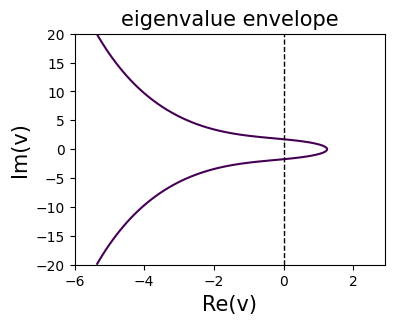

In [295]:
#Envelope of a characteristic equation of a delay system

x = np.arange(-6, 3, 0.1)
y = np.arange(-20, 20+1e-5, 0.2)
X, Y = np.meshgrid(x, y)
Z = X**2+Y**2-1-2*np.exp(-1*X)
fig = plt.figure(figsize = (4,3))
ax = fig.add_subplot(111)
ax.contour(X, Y, Z, [0])
ax.axvline(0, c = "black", linestyle = "--", linewidth = 1)
ax.set_xlabel("Re(v)", fontsize = 15)
ax.set_ylabel("Im(v)", fontsize = 15)
ax.set_title("eigenvalue envelope", fontsize = 15)

plt.savefig("PATH.svg", bbox_inches = "tight")

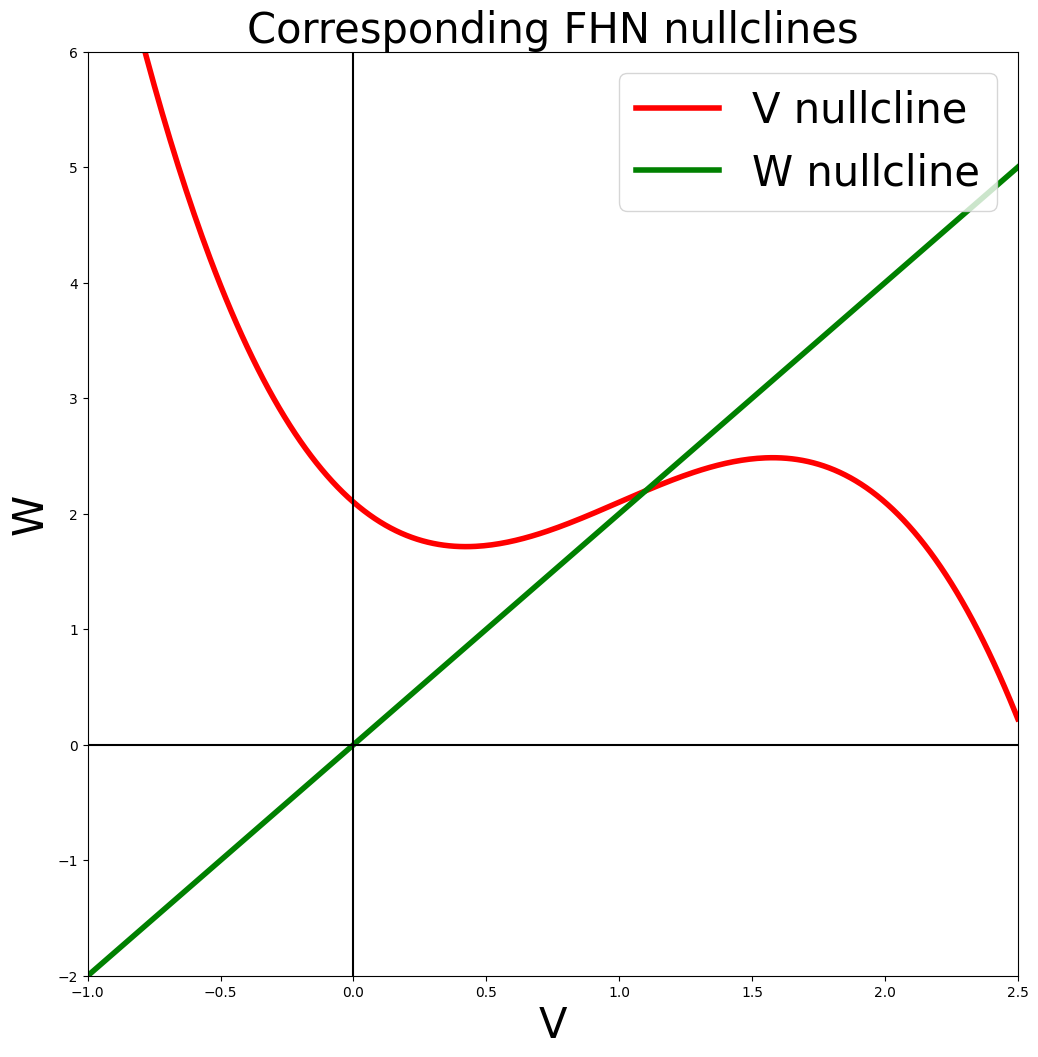

In [566]:
#graph of the FHN nulllclines

def fhn_v(x, I):
    return x*(x-2)*(1-x) - I

def fhn_w(x):
    return 2*x

fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)

xs = np.arange(-1, 2.5+1e-15, 0.01)
ax.plot(xs, fhn_v(xs, -2.1), c = "red", label = "V nullcline", linewidth = 4)
ax.plot(xs, fhn_w(xs), c = "green", label = "W nullcline", linewidth = 4)
ax.axhline(0, c = "black")
ax.axvline(0, c = "black")
ax.legend(fontsize = 30, loc = "upper right")
ax.set_xlabel("V", fontsize = 30)
ax.set_ylabel("W", fontsize = 30)
ax.set_title("Corresponding FHN nullclines", fontsize = 30)
ax.set_xlim(-1, 2.5)
ax.set_ylim(-2, 6)
plt.savefig("C:\\Users\\Andrzej Socha\\Desktop\\MSF graphs\\nullcs I=-2,1.png", bbox_inches = "tight")

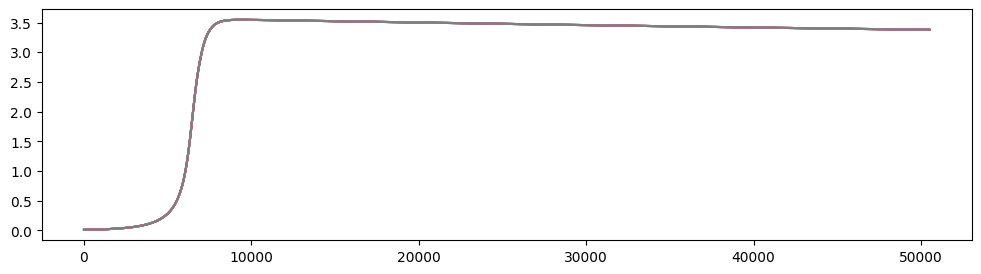

In [66]:
#Simulating the graph

a = np.zeros(16)
a.fill(0.01)
for i in range(int(a.size/2)):
    a[2*i+1] = 0

cf = 1
#cm = Diffusive_ring_matrix(8)
cm = 5 * np.identity(8)
dm = np.array([[1,0],[0,0]])
tau = 0.5
time_step = 1e-3
total_time = 50
graph = np.array(simulate_graph(graph_fhn, a, cf, cm, dm, tau, time_step, total_time, 2, 2, 1, 0.01, 0))
fig = plt.figure(figsize=(12,3))
ax = fig.add_subplot(111)
for i in range(int(len(graph[0])/2)):
    ax.plot(graph[:,2*i])
plt.show()

In [ ]:
Lyapunov_calc_2(1, [0,0], 1e-4, 1, int(1e+3), int(1e+6), 1e-4, 10)

0.014895446899475475

In [559]:
#graph of maxima

xs = []
lyaps = []
for x in np.arange(-2, 10+1e-15, 0.05):
    val = Lyapunov_calc_2(x, [0,0], 1e-4, 1, int(1e+3), int(1e+6), 1e-4, 1e+10)
    print(round(x, 2), val)
    xs2.append(x)
    lyaps2.append(val)

-2.0 -0.17433452378248526
-1.95 -0.17573728372535055
-1.9 -0.17719604100446948
-1.85 -0.17871435800916638
-1.8 -0.18029611651520527
-1.75 -0.1819455554384688
-1.7 -0.18366731423881563
-1.65 -0.18546648300599397
-1.6 -0.18734866049323295
-1.55 -0.1893200216534878
-1.5 -0.19138739658669987
-1.45 -0.19355836329524198
-1.4 -0.19584135724422488
-1.35 -0.19824580147372542
-1.3 -0.20078226208715386
-1.25 -0.20346263528896547
-1.2 -0.20630037393423745
-1.15 -0.20931076409216146
-1.1 -0.2125112654598453
-1.05 -0.21592193425642503
-1.0 -0.21956595379899305
-0.95 -0.22347030766460874
-0.9 -0.22766664420214716
-0.85 -0.2321924020963595
-0.8 -0.237092298468504
-0.75 -0.24242033061470106
-0.7 -0.24824252250004114
-0.65 -0.25464077976938165
-0.6 -0.261718445975666
-0.55 -0.26960856483993983
-0.5 -0.27848663531264806
-0.45 -0.28859122359499056
-0.4 -0.3002592329948537
-0.35 -0.3139908797285796
-0.3 -0.33058190501603407
-0.25 -0.35143376954502104
-0.2 -0.37946589334407677
-0.15 -0.42330455972992853
-0.

Text(0.5, 1.0, 'largest Lyapunov exponent, I=-1.3, tau=0')

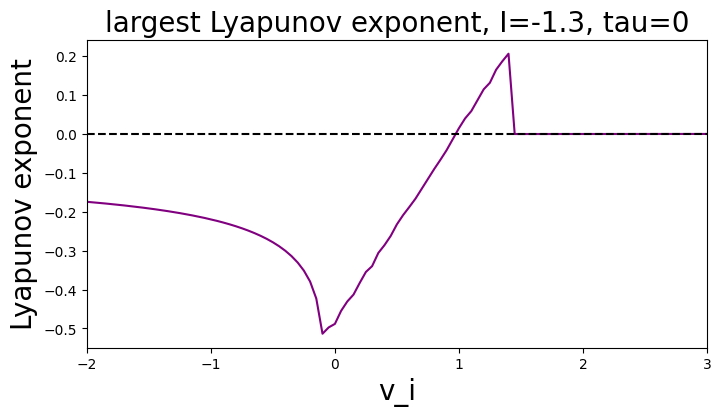

In [564]:
fig = plt.figure(figsize=(8,4))
ax = fig.add_subplot(111)

ax.plot(xs2[::], lyaps2[::], c="purple", label="Lyapunov exponent")
#ax.set_yscale("log")
ax.set_xlim(-2,3)
ax.axhline(0, c="black", linestyle="--")
ax.set_xlabel("v_i", fontsize = 20)
ax.set_ylabel("Lyapunov exponent", fontsize = 20)
ax.set_title("largest Lyapunov exponent, I=-1.3, tau=0", fontsize = 20)


In [563]:
lyaps

[]

In [ ]:
a = np.arange(1, 2+1e-15, 0.2)
for i, x in enumerate(a):
    print(f'{x}, Lyap = {Lyapunov_calc(x, [0.5,0.5], int(1e+5), int(1e+6), 1e-4, 1e+11)}')

In [196]:
a = np.ones((4,4))
b = np.array([[1,2],[3,1]])
Kronecker(b,a)

array([[1., 1., 1., 1., 2., 2., 2., 2.],
       [1., 1., 1., 1., 2., 2., 2., 2.],
       [1., 1., 1., 1., 2., 2., 2., 2.],
       [1., 1., 1., 1., 2., 2., 2., 2.],
       [3., 3., 3., 3., 1., 1., 1., 1.],
       [3., 3., 3., 3., 1., 1., 1., 1.],
       [3., 3., 3., 3., 1., 1., 1., 1.],
       [3., 3., 3., 3., 1., 1., 1., 1.]])

In [217]:
np.arange(0,10+1e-15,0.5)

array([ 0. ,  0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ,
        5.5,  6. ,  6.5,  7. ,  7.5,  8. ,  8.5,  9. ,  9.5, 10. ])

In [334]:
modified = []
for i in range(len(data)):
    IM = i * 0.2 - 1
    done = np.append(data[i], Lyap(2, IM))
    modified.append(done)
    print(i)
print(modified)

0
1
2
3
4
5
6
7
8
9
10
[array([0.19837291, 0.18274733, 0.16843138, 0.15613954, 0.1463583 ,
       0.13914689, 0.13417412, 0.13099443, 0.1293719 , 0.12947593,
       0.13186225, 0.13719822, 0.14581797, 0.15742104, 0.17118342,
       0.18613586, 0.20146861, 0.21663202, 0.23130501, 0.24532584,
       0.25863117]), array([0.18369037, 0.16543207, 0.1485297 , 0.13413983, 0.12310353,
       0.11544504, 0.11039396, 0.10697149, 0.1046329 , 0.10364239,
       0.10512128, 0.11058251, 0.12088246, 0.13543312, 0.15262131,
       0.17081565, 0.18890368, 0.2062901 , 0.22271951, 0.23812236,
       0.25252005]), array([0.16979767, 0.14833659, 0.12806118, 0.11087459, 0.09838355,
       0.09062402, 0.0859637 , 0.08240712, 0.07880077, 0.0754336 ,
       0.07441222, 0.07922301, 0.09207574, 0.11139836, 0.13362331,
       0.1560375 , 0.17734284, 0.19711006, 0.21530044, 0.23202159,
       0.24742271]), array([0.15784634, 0.13281892, 0.10836825, 0.08746588, 0.07326476,
       0.06602535, 0.06252478, 0.0590413 ,

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

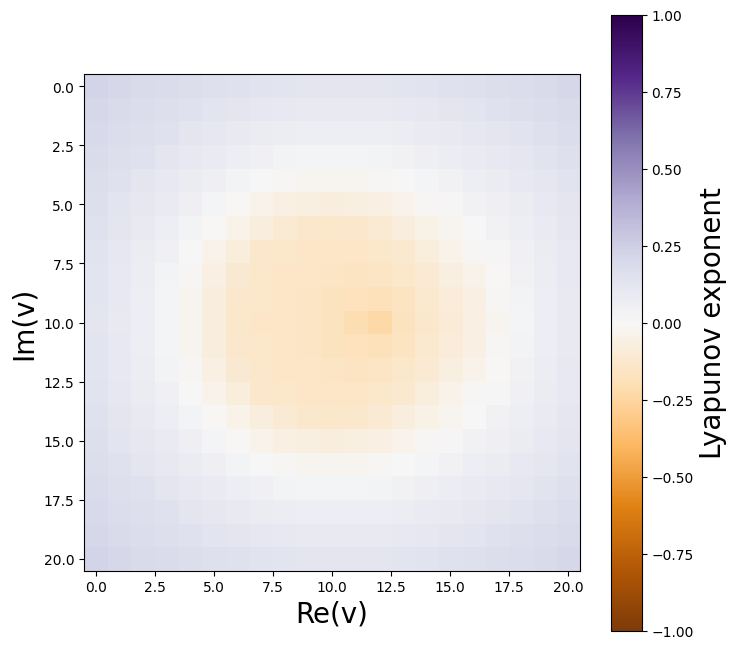

[[ 0.22478936  0.20992839  0.19523798  0.18093664  0.16729765  0.15464803
   0.14335816  0.13381815  0.12640027  0.12141124  0.11904506  0.119351
   0.12222886  0.1274544   0.13472638  0.1437199   0.15413119  0.16570301
   0.17822461  0.19150846  0.20536179]
 [ 0.21027778  0.19382454  0.17738241  0.16118791  0.14555471  0.13087978
   0.11763717  0.10635126  0.09754406  0.09165934  0.08898069  0.08957215
   0.09326785  0.09971778  0.10847112  0.11906633  0.13110291  0.14428121
   0.15839844  0.17329248  0.1887656 ]
 [ 0.19593733  0.17772339  0.15929587  0.14089673  0.12287271  0.10569557
   0.08996867  0.07640379  0.06575139  0.05867952  0.05562595  0.05668125
   0.06156493  0.06971257  0.08043021  0.09304707  0.1070249   0.12202026
   0.1378901   0.15458065  0.17191711]
 [ 0.18198356  0.1618527   0.14120283  0.12025716  0.09937361  0.07908939
   0.06015721  0.04354468  0.03035578  0.0216413   0.01812222  0.01994353
   0.02661463  0.03718999  0.05057453  0.06578401  0.08208731  0.099081

In [256]:
def Lyap(a, b):
    return Lyapunov_calc_2(Complex(a,b), [0,0], 1e-4, 1, int(1e+3), int(1e+6), 1e-4, 1e+11)

fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)

Re = np.arange(-5, 5.01, 0.5)
Im = np.arange(-5, 5.01, 0.5)

data = np.zeros((Im.size, Re.size))
for c, vc in enumerate(Im):
    for r, vr in enumerate(Re):
        data[c,r] = Lyap(vr, vc)
        print(c*Re.size+r)

im = ax.imshow(data, cmap = "PuOr", vmin=-1, vmax=1)
ax.set_ylabel('Im(v)', fontsize = 20)
ax.set_xlabel('Re(v)', fontsize = 20)

cbar = plt.colorbar(im)
cbar.set_label('Lyapunov exponent', fontsize = 20)
plt.show()
print(data)

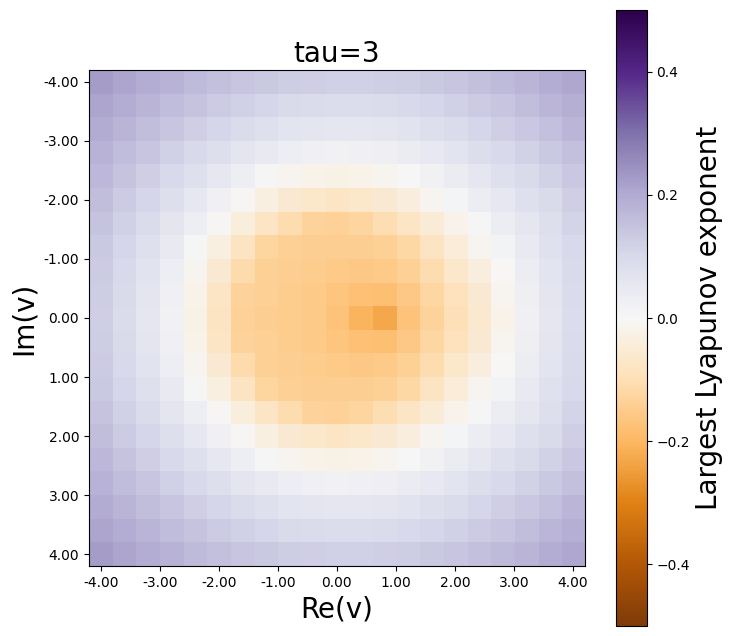

In [270]:
fig = plt.figure(figsize = (8,8))
ax = fig.add_subplot(111)


im = ax.imshow(data, cmap = "PuOr", vmin=-0.5, vmax=0.5)
ax.set_ylabel('Im(v)', fontsize = 20)
ax.set_xlabel('Re(v)', fontsize = 20)
ax.xaxis.set(ticks=[2.5*i for i in range(0, 9)], ticklabels=[f'{j-4:.2f}' for j in range(9)])
ax.yaxis.set(ticks=[2.5*i for i in range(0, 9)], ticklabels=[f'{i - 4:.2f}' for i in range(9)])
#ax.get_xaxis().set_major_formatter(matplotlib.ticker.ScalarFormatter())

ax.set_title("tau=3", fontsize=20)
cbar = plt.colorbar(im)
cbar.set_label('Largest Lyapunov exponent', fontsize = 20)
plt.savefig("C:\\Users\\Andrzej Socha\\Desktop\\MSF graphs\\t=3 zoom.svg")

In [330]:
data1 = deepcopy(data)

# 